### In this notebook we compare the timing of encoding operations:
- count encoding.
- target encoding.
- label encoding.

In [1]:
import os
GPU_id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import cudf as gd
import pandas as pd
import numpy as np
import os
import time
import nvstrings
from librmm_cffi import librmm
import matplotlib.pyplot as plt
%matplotlib inline

### Global

In [3]:
GPU_RUN_TIME = {}
CPU_RUN_TIME = {}
STEPS = []

### Functions

In [4]:
def on_gpu(words,func,arg=None,dtype=np.int32):
    res = librmm.device_array(words.size(), dtype=dtype)
    if arg is None:
        cmd = 'words.%s(devptr=res.device_ctypes_pointer.value)'%(func)
    else:
        cmd = 'words.%s(arg,devptr=res.device_ctypes_pointer.value)'%(func)
    eval(cmd)
    return res

def count_items(data,cols):
    dg = data.groupby(cols+['item_id'],
            as_index=False).agg({'step':['count']})
    if len(cols) == 0:
        tag = 'global'
    else:
        tag = '_'.join(cols)
    dg.columns = cols + ['item_id', 'count_item_%s'%tag]

    if len(cols):
        df = data.groupby(cols,
            as_index=False).agg({'step':['count']})
        df.columns = cols + ['count_item_%s_all'%tag]
    
        dg = dg.merge(df,on=cols,how='left')
        dg['count_item_%s_norm'%tag] = dg['count_item_%s'%tag] / dg['count_item_%s_all'%tag]
    
        dg = dg.drop('count_item_%s_all'%tag,axis=1)
        del df
    return dg

In [5]:
YCOL = 'target'
def mtr(tr,cols,te):
    cols = cols + ['item_id']    
    dg = tr.groupby(cols,as_index=False).agg({YCOL:'mean'})
    if len(cols):
        mcol = 'mtr_%s'%('_'.join(cols))
    else:
        mcol = 'mtr_global'
    dg.columns = cols+[mcol]
    te = te.merge(dg,on=cols,how='left')
    del dg
    return te,mcol

def mtr_encode(train,test,cols):
    # data should have these columns:
    # row_id, column to compute mtr, target, item_id
    # clickout_missing and all_row_id
    train_x = train[cols+['item_id','row_id','all_row_id',YCOL]]
    res = []
    for i in range(8):
        tr = train_x[train_x['row_id']%8!=i]
        va = train_x[train_x['row_id']%8==i]
        va,mcol = mtr(tr,cols,va)
        res.append(va)
        print(cols,'fold',i,'done')
        del tr,va
    if isinstance(train,gd.DataFrame):
        res = gd.concat(res)
    else:
        res = pd.concat(res)
    for col in res.columns:
        if col not in ['all_row_id',mcol]:
            res = res.drop(col,axis=1)
    train = train.merge(res,on='all_row_id',how='left')
    del res
    test,_ = mtr(train_x,cols,test)
    del train_x
    return train,test,mcol

### Read pair data

In [6]:
if os.path.exists('cache')==False:
    os.mkdir('cache')

In [7]:
path = '/datasets/trivago/data/'

In [8]:
step = 'prepare for target encoding'
STEPS.append(step)

In [9]:
%%time
start = time.time()

cols = ['row_id','current_filters','target','user_id',
        'item_id','clickout_missing','city','device']
data_pair_pd = pd.read_pickle('cache/data_pair_gd.pkl')[cols]

data_pair_pd['all_row_id'] = np.arange(data_pair_pd.shape[0])
cols.append('all_row_id')
data_pair_pd['current_filters'] = data_pair_pd['current_filters'].fillna('None')

train_pair_pd = data_pair_pd[data_pair_pd['clickout_missing']==0]
test_pair_pd = data_pair_pd[data_pair_pd['clickout_missing']>0]
print(train_pair_pd.shape,test_pair_pd.shape)

CPU_RUN_TIME[step] = time.time() - start

(42756036, 9) (5762533, 9)
CPU times: user 1min 16s, sys: 49.7 s, total: 2min 6s
Wall time: 52.5 s


In [10]:
%%time
start = time.time()

data_pair_gd = gd.from_pandas(data_pair_pd)
data_pair_gd['current_filters'] = data_pair_gd['current_filters'].fillna('None')
train_pair_gd = data_pair_gd[data_pair_gd['clickout_missing']==0]
test_pair_gd = data_pair_gd[data_pair_gd['clickout_missing']>0]
print(train_pair_gd.shape,test_pair_gd.shape)
del data_pair_gd
del data_pair_pd

GPU_RUN_TIME[step] = time.time() - start

(42756036, 9) (5762533, 9)
CPU times: user 24.4 s, sys: 15.2 s, total: 39.6 s
Wall time: 26.6 s


### mean target encoding

In [11]:
step = 'mean target encoding'
STEPS.append(step)

### cudf mean target encoding

In practice we also computed n-way mean target encoding as follows:
- ['current_filters','city'],
- ['current_filters','city','device'],
- ['current_filters','device'],
- ['current_filters','platform'],

*which are not included in this notebook due to memory capacity bottleneck*

In [12]:
%%time
start = time.time()

for cols in [
    ['current_filters'],
    ['city'],
    ['device'],
    ['user_id'],
]:
    
    train_pair_gd,test_pair_gd,mcol = mtr_encode(train_pair_gd,test_pair_gd,cols=cols)
print('mtr done')

GPU_RUN_TIME[step] = time.time() - start

['current_filters'] fold 0 done
['current_filters'] fold 1 done
['current_filters'] fold 2 done
['current_filters'] fold 3 done
['current_filters'] fold 4 done
['current_filters'] fold 5 done
['current_filters'] fold 6 done
['current_filters'] fold 7 done
['city'] fold 0 done
['city'] fold 1 done
['city'] fold 2 done
['city'] fold 3 done
['city'] fold 4 done
['city'] fold 5 done
['city'] fold 6 done
['city'] fold 7 done
['device'] fold 0 done
['device'] fold 1 done
['device'] fold 2 done
['device'] fold 3 done
['device'] fold 4 done
['device'] fold 5 done
['device'] fold 6 done
['device'] fold 7 done
['user_id'] fold 0 done
['user_id'] fold 1 done
['user_id'] fold 2 done
['user_id'] fold 3 done
['user_id'] fold 4 done
['user_id'] fold 5 done
['user_id'] fold 6 done
['user_id'] fold 7 done
mtr done
CPU times: user 2min 43s, sys: 52.9 s, total: 3min 36s
Wall time: 1min 48s


In [13]:
%%time
start = time.time()

for cols in [
    ['current_filters'],
    ['city'],
    ['device'],
    ['user_id'],
]:
    
    train_pair_pd,test_pair_pd,mcol = mtr_encode(train_pair_pd,test_pair_pd,cols=cols)
print('mtr done')

CPU_RUN_TIME[step] = time.time() - start

['current_filters'] fold 0 done
['current_filters'] fold 1 done
['current_filters'] fold 2 done
['current_filters'] fold 3 done
['current_filters'] fold 4 done
['current_filters'] fold 5 done
['current_filters'] fold 6 done
['current_filters'] fold 7 done
['city'] fold 0 done
['city'] fold 1 done
['city'] fold 2 done
['city'] fold 3 done
['city'] fold 4 done
['city'] fold 5 done
['city'] fold 6 done
['city'] fold 7 done
['device'] fold 0 done
['device'] fold 1 done
['device'] fold 2 done
['device'] fold 3 done
['device'] fold 4 done
['device'] fold 5 done
['device'] fold 6 done
['device'] fold 7 done
['user_id'] fold 0 done
['user_id'] fold 1 done
['user_id'] fold 2 done
['user_id'] fold 3 done
['user_id'] fold 4 done
['user_id'] fold 5 done
['user_id'] fold 6 done
['user_id'] fold 7 done
mtr done
CPU times: user 39min 59s, sys: 7min 22s, total: 47min 21s
Wall time: 17min 51s


### Visualize the timing

In [14]:
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in STEPS])
CPU_RUN_TIME['Overall'] = sum([CPU_RUN_TIME[i] for i in STEPS])
STEPS.append('Overall')

timing = pd.DataFrame()
timing['step'] = STEPS
timing['GPU'] = [GPU_RUN_TIME[i] for i in STEPS]
timing['CPU'] = [CPU_RUN_TIME[i] for i in STEPS]
timing

,step,GPU,CPU
0,prepare for target encoding,26.562680,52.523889
1,mean target encoding,108.592582,1071.832316
2,Overall,135.155262,1124.356205


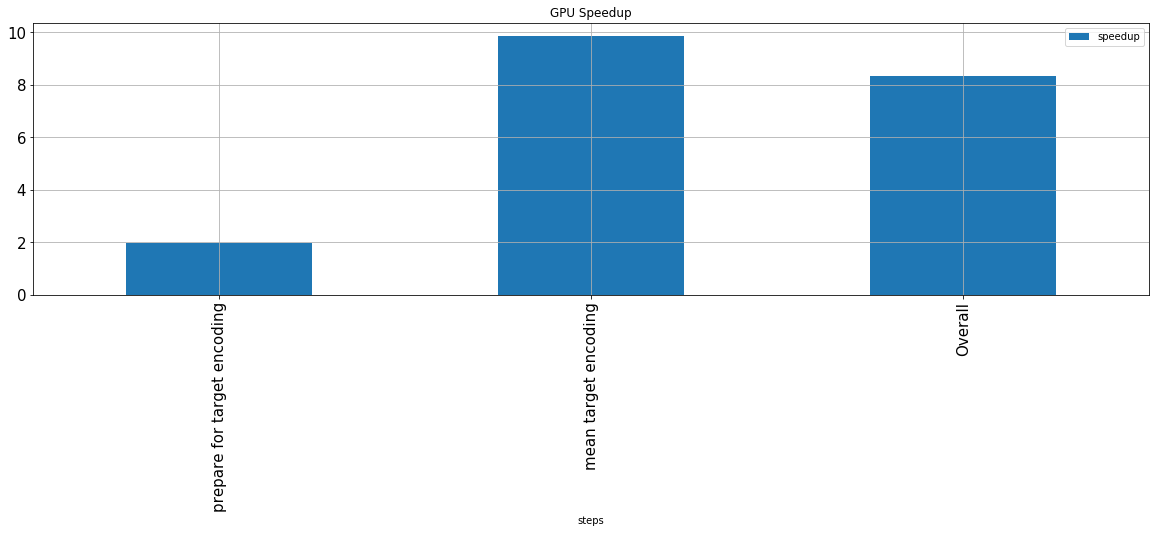

In [15]:
speedup = [CPU_RUN_TIME[i]/GPU_RUN_TIME[i] for i in STEPS]
df = pd.DataFrame({'steps':STEPS, 'speedup':speedup})
ax = df.plot.bar(x='steps', y='speedup', figsize=(20,5), fontsize=15, title='GPU Speedup',grid=True)

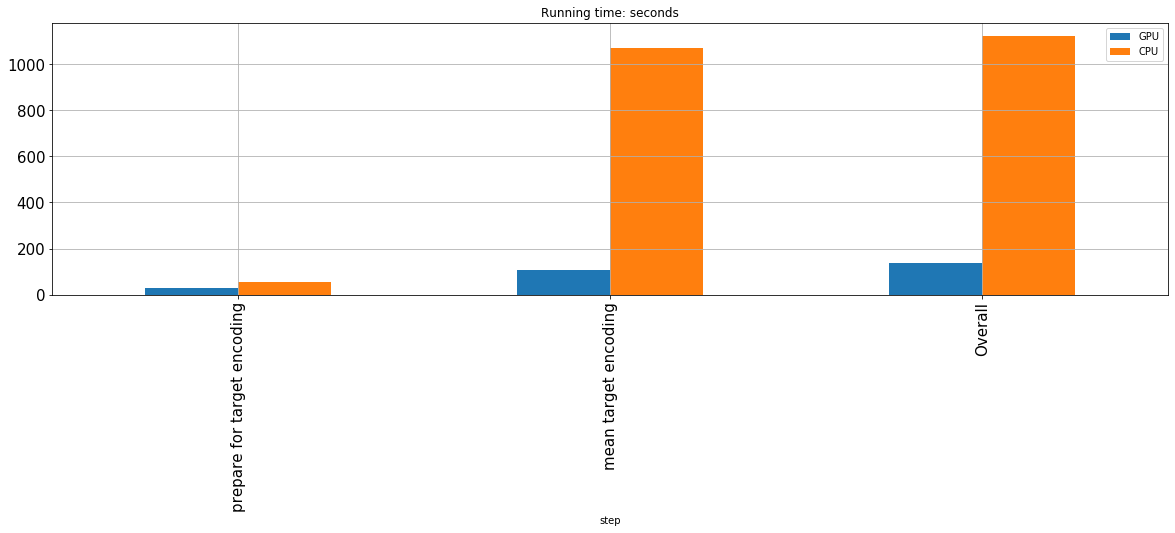

In [16]:
timing.set_index('step').plot.bar(figsize=(20,5),grid=True,fontsize=15, title='Running time: seconds')